# MCMC Plots v2
This notebook is to produce relevant results plots for MCMC data

v2 is a streamlined version incorporating features present as of 5 May 2020
It uses results calculated in the notebook R68_MCMC_process

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *
import R68_spec_tools as spec
import R68_yield as Yield
from tqdm.notebook import tqdm
from matplotlib.pyplot import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


In [3]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [4]:
#Load the MCMC data
import pickle as pkl

#fname='data/mcmc_Lind_128walk_5kstep_SNorm_v16.pkl'
fname='data/mcmc_Chav_128walk_5kstep_SNorm_v6.pkl'
#fname='data/mcmc_Sor_128walk_5kstep_SNorm_v11.pkl'
#fname='data/mcmc_AC_128walk_5kstep_SNorm_v4.pkl'
#fname='data/mcmc_Shexp_128walk_50kstep_SNorm_v1.pkl'
#fname='data/mcmc_Pol3_128walk_5kstep_SNorm_v1.pkl'

############################
basename=os.path.splitext(os.path.basename(fname))[0]

with open(fname,'rb') as file:
    mcmc_data=pkl.load(file)
sampler=mcmc_data['sampler']
guesses=mcmc_data['guesses']
labels=mcmc_data['labels']
model=mcmc_data['Ymodel']
RQs=mcmc_data['RQs']

In [5]:
if 'll' in RQs.keys():
    print(f"{RQs['ll']:.1f}, {RQs['chisq']:.1f}/{RQs['dof']:.1f}={RQs['chisq']/RQs['dof']:.2f}")

805.8, 826.4/165.0=5.01


In [6]:
print(f'{mcmc_data["t_run"]/60:.1f} min')
print(mcmc_data["spectrum_units"])

1379.8 min
reco-rate


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


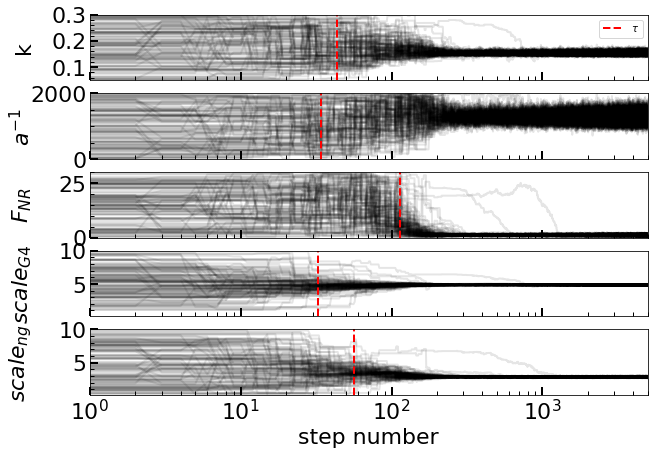

In [7]:
#Look at the chain of parameter values
samples = sampler.get_chain()
ndim = samples.shape[2]

fig, axes = subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.1)
    
    ax.axvline(mcmc_data['RQs']['taus'][i],color='r',linestyle='--',label=r'$\tau$')
    
    ax.set_xlim(1, len(samples))
    ax.set_ylim(*(mcmc_data['theta_bounds'][i]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[-1].set_xscale("log");
axes[0].legend(loc='upper right')

savefig('figures/mcmc/'+basename+'_chains.png')

Text(0, 0.5, 'Counts')

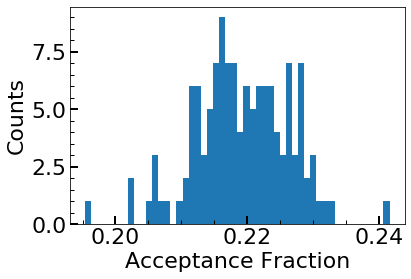

In [8]:
hist(sampler.acceptance_fraction,bins=50);
xlabel('Acceptance Fraction')
ylabel('Counts')

In [9]:
tau=sampler.get_autocorr_time(tol=0)
maxtau=RQs['maxtau']
print(f'Max tau={maxtau:.1f}')
print(f'Full chain is {samples.shape[0]/maxtau:.1f} tau_max long')
#Discard a few times tau as burn-in and thin by tau/2
flat_samples = sampler.get_chain(discard=int(2.*maxtau), thin=int(round(maxtau/2.)), flat=True)

Max tau=113.0
Full chain is 44.2 tau_max long


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


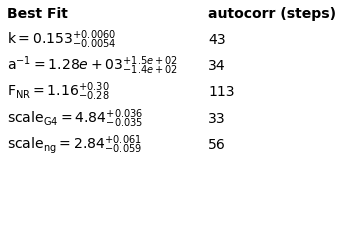

In [10]:
#Save a figure of some stats
fig,ax=plt.subplots()
ax.text(0,1,r'Best Fit',fontsize=14,fontweight='bold');
ax.text(0.6,1,r'autocorr (steps)',fontsize=14,fontweight='bold');

#txt = r'$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$'
txt = r'$\mathrm{{{3}}} = {0:#.3g}_{{-{1:#.2g}}}^{{+{2:#.2g}}}$'
for i in range(ndim):
    line = txt.format(RQs['theta'][i], RQs['dtheta'][i][0], RQs['dtheta'][i][1], labels[i].replace('$',''))
    #ax.text(0,i*0.1,r'$\mathrm{F_{NR}}$',fontsize=14)
    ax.text(0,1-(i+1)*0.12,line,fontsize=14);
    ax.text(0.6,1-(i+1)*0.12,'{0:.0f}'.format(tau[i]),fontsize=14);
ax.axis('off');
plt.savefig('figures/mcmc/'+basename+'_stats.png')

<Figure size 1080x810 with 0 Axes>

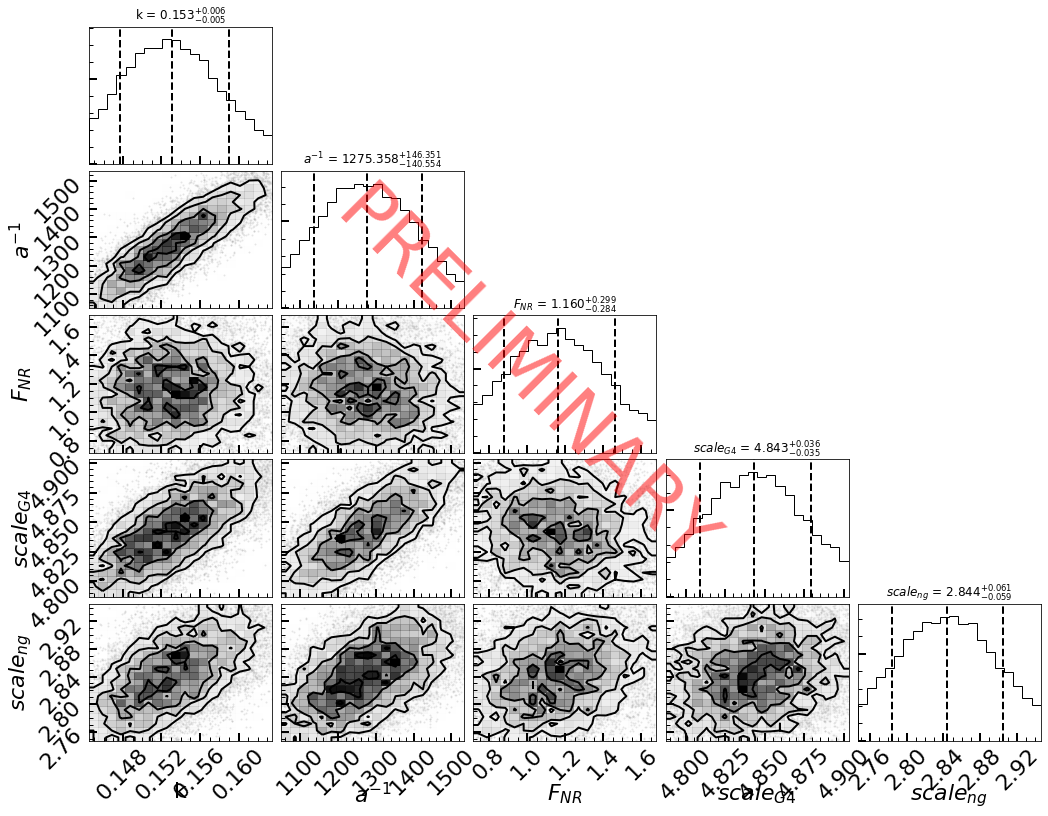

In [11]:
#Make the corner plots
import corner

#Full prior range
fig_w=15
fig,ax = subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))

fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f', 
    fig=fig,range=mcmc_data['theta_bounds']);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
savefig('figures/mcmc/'+basename+'_corner_full.png')

#Zoomed version
plt.clf()
fig,ax = subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f',
    fig=fig,range=[np.percentile(flat_samples[:,_], [5, 95]) for _ in range(ndim)]);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
savefig('figures/mcmc/'+basename+'_corner.png')

# Show best fit spectrum
Copied this code right out of the R68_MCMC_MPI file

In [12]:
import R68_load as r68
import R68_spec_tools as spec
#Import likelihood functions
from likelihoods import *

#Set eVee energy binning
Emax=mcmc_data['Emax']
Ebins=mcmc_data['Ebins']
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2

#Set fit range
E_lim_min=mcmc_data['Efit_min'] #eVee
E_lim_max=mcmc_data['Efit_max'] #eVee
spec_bounds=(np.digitize(E_lim_min,Ebins)-1,np.digitize(E_lim_max,Ebins)-1)
mcmc_data['spec_bounds']=spec_bounds

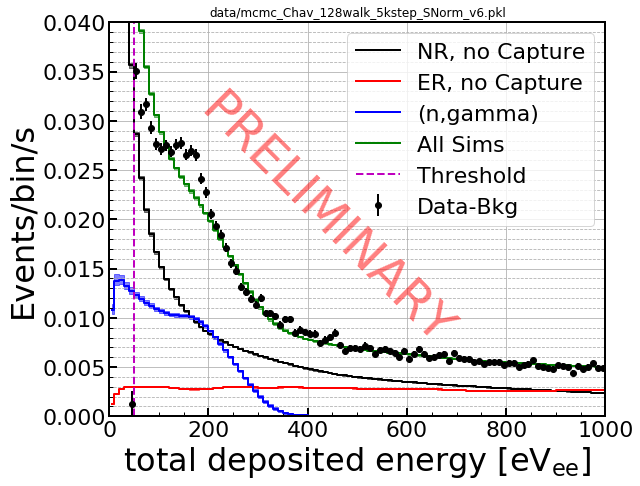

In [13]:
saveSpec=True #Save the plot

if mcmc_data['spectrum_units']=='counts':
    yrange=(0,3e3)
elif mcmc_data['spectrum_units']=='reco-rate':
    yrange=(0,4e-2)
#Make the plot
ax=spec.plotSpectra(E_bins=Ebins, N_nr=RQs['N_nr_plot'], N_er=RQs['N_er_plot'], N_ng=RQs['N_ng_plot'], N_tot=RQs['N_tot_plot'],
                    N_meas=RQs['N_meas'], dN_meas=RQs['dN_meas'],
                    xrange=(0,1e3), yrange=yrange, thresh=Ebins[np.digitize(mcmc_data['Efit_min'],Ebins)-1],
                    wResidual=False, yrange_res=(-100,100))
        
ax.set_title(fname)
gcf().text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5);
if saveSpec:
    savefig('figures/mcmc/'+basename+'_spectrum.png')

In [14]:
#Best fit chisq and Likelihood
print(f'Chisq/DOF:\t{RQs["chisq"]:.4g}/{RQs["dof"]}=\t{RQs["chisq"]/RQs["dof"]:.3g}\nlogLikelihood:\t{RQs["ll"]:.4g}')

Chisq/DOF:	826.4/165=	5.01
logLikelihood:	805.8


# Yield curve

In [15]:
from scipy.optimize import fsolve
from scipy.special import erf

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

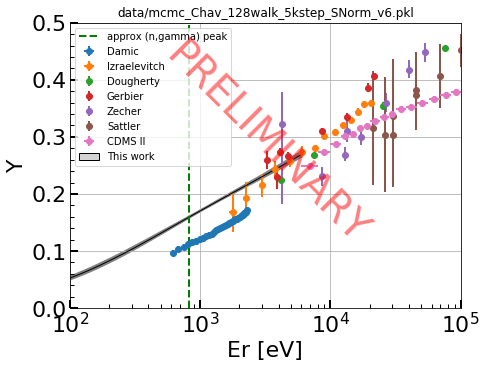

In [16]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches


#This work
Y=Yield.Yield('Lind',[0.2])
Y.set_model(mcmc_data['Ymodel'])
nYpar=Y.model_npar[mcmc_data['Ymodel']]
Y.set_pars(RQs['theta'][:nYpar])
Y.solve()
thresh_low_NR=ERtoNR(mcmc_data['Efit_min'],Y,V,eps)[0]
thresh_high_NR=ERtoNR(2e3,Y,V,eps)[0]

fig_w=7
fig,ax = subplots(1,1,figsize=(fig_w, fig_w*(.75)))


#TODO: Determine this range
#Er_plot=np.linspace(thresh_low_NR,thresh_high_NR,100)
Er_plot=np.linspace(0,thresh_high_NR,100)

#Add other measurements from lit
pt.plotOldYs(ax,fmt='o')

Ydist=RQs['Ydist']
ax.fill_between(RQs['Er_Ycalc'],Ydist[1],Ydist[2],color='gray')
ax.plot(RQs['Er_Ycalc'], Ydist[0], '-k', linewidth=1)

#Y.set_pars(theta[:nYpar])
#Y.solve()
#ax.plot(Er_plot, Y.calc(Er_plot), '--k', linewidth=2)

ax.axvline(ERtoNR(150,Y,V,eps), color='g', linestyle='--', label='approx (n,gamma) peak')

#Manually add legend entry
handles, Ylabels = ax.get_legend_handles_labels()
patch = mpatches.Patch(facecolor='lightgray',edgecolor='k', label='This work')
handles.append(patch) 

ax.legend(handles=handles, loc='upper left')

ax.set_xscale('log')
ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
ax.set_xlim(1e2,1e5);
ax.set_ylim(0,0.5);
ax.grid()

ax.set_title(fname)
fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

savefig('figures/mcmc/'+basename+'_yield_compare.png')

# Compare different MCMCs on the same plots

In [19]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches


fnames=['data/mcmc_Sor_128walk_5kstep_SNorm_v17.pkl',
        'data/mcmc_Sor_128walk_5kstep_SNorm_v18.pkl']
plot_fill_colors=['k','blue','gray']
plot_line_colors=['white','white','white']
plot_zorders=[2,1,0]
plot_labels=['This work: Stat','Stat+Syst']#,'+BurstSyst']

fullNames={'Lind':'Lindhard','Sor':'Sorensen'}

mcmc_datas=[]
for fname in fnames:
    with open(fname,'rb') as file:
        mcmc_datas.append(pkl.load(file))
RQss=[]
for datai in mcmc_datas:
    RQss.append(datai['RQs'])

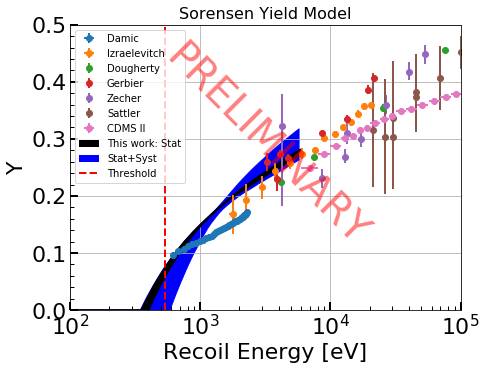

In [21]:
fig_w=7
fig,ax = subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#Get the best fit(ish) curve
Y.set_model(mcmc_datas[0]['Ymodel'])
nYpar=Y.model_npar[mcmc_datas[0]['Ymodel']]
Y.set_pars(mcmc_datas[0]['RQs']['theta'][:nYpar])
Y.solve()

thresh_low_NR=ERtoNR(mcmc_datas[0]['Efit_min'],Y,V,eps)[0]
thresh_high_NR=ERtoNR(2e3,Y,V,eps)[0]


for i,RQi in enumerate(RQss):
    ax.fill_between(RQi['Er_Ycalc'],RQi['Ydist'][1],RQi['Ydist'][2],color=plot_fill_colors[i],zorder=plot_zorders[i])
    #ax.plot(RQi['Er_Ycalc'], RQi['Ydist'][0], '-k', linewidth=1, color=plot_line_colors[i])


#Add other measurements from lit
pt.plotOldYs(ax,fmt='o')
    
#Manually add legend entries
handles, Ylabels = ax.get_legend_handles_labels()
for col,lab in zip(plot_fill_colors,plot_labels):
    patch = mpatches.Patch(facecolor=col, label=lab)
    handles.append(patch) 

#Single recoil threshold
line_thresh=ax.axvline(thresh_low_NR, color='r', linestyle='--', label='Threshold')
handles.append(line_thresh)

ax.legend(handles=handles, loc='upper left')

ax.set_xscale('log')
ax.set_xlabel('Recoil Energy [eV]')
ax.set_ylabel('Y')
ax.set_xlim(1e2,1e5);
ax.set_ylim(0,0.5);
ax.grid()

ax.set_title(f"{fullNames[mcmc_datas[0]['Ymodel']]} Yield Model",size=16)

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)
tight_layout
#savefig('figures/mcmc/Sor_yield_wSyst.png')